__Author: Стурейко Игорь__

__Project: Geekbrains.NeutralNets__

__Lesson 6 - Segmentation__

__Date: 2021-12-23__

# Задание

1. обучить нейронную сеть U-Net на любом другом датасете.

2. *Попробуйте свои силы в задаче Carvana на Kaggle - https://www.kaggle.com/c/carvana-image-masking-challenge/overview4.

# Решение
1. Фактически нужно описать статическую часть по загрузке и подготовке данных для обучения
2. Добавить часть по сбору и компиляции сети 
3. Запуск обучения - смотрим на результат

## Imports

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
import numpy as np
from PIL import Image
import tensorflow as tf
import cv2
import os, fnmatch

In [2]:
# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Загрузка данных

In [3]:
PAHT_label = 'Carvana/train_mask/'
PAHT_image = 'Carvana/train/'

In [4]:
imag_label = os.listdir(PAHT_label)
imag = os.listdir(PAHT_image)

In [5]:
imag.sort()
imag[:10]

['00087a6bd4dc_01.jpg',
 '00087a6bd4dc_02.jpg',
 '00087a6bd4dc_03.jpg',
 '00087a6bd4dc_04.jpg',
 '00087a6bd4dc_05.jpg',
 '00087a6bd4dc_06.jpg',
 '00087a6bd4dc_07.jpg',
 '00087a6bd4dc_08.jpg',
 '00087a6bd4dc_09.jpg',
 '00087a6bd4dc_10.jpg']

In [6]:
imag_label.sort()
imag_label[:10]

['00087a6bd4dc_01_mask.gif.jpg',
 '00087a6bd4dc_02_mask.gif.jpg',
 '00087a6bd4dc_03_mask.gif.jpg',
 '00087a6bd4dc_04_mask.gif.jpg',
 '00087a6bd4dc_05_mask.gif.jpg',
 '00087a6bd4dc_06_mask.gif.jpg',
 '00087a6bd4dc_07_mask.gif.jpg',
 '00087a6bd4dc_08_mask.gif.jpg',
 '00087a6bd4dc_09_mask.gif.jpg',
 '00087a6bd4dc_10_mask.gif.jpg']

In [7]:
len(imag)

5088

In [22]:
# convert gif to jpg

# for i_name in os.listdir('Carvana/train_mask'):
#     Image.open(str('Carvana/train_mask/' + i_name)).convert('RGB').save(str('Carvana/train_mask/' + i_name+'.jpg'))

In [14]:
images = []
segments = []
image_size = (200,600)
for i_name in imag[:100]:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))

for i_name in imag_label[:100]:
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

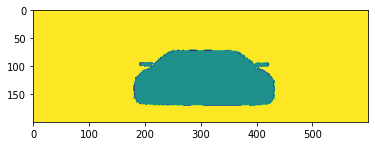

In [23]:
def Color2index(y):
  arr_col=[[255,255,255],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
# cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
# plt.imshow(ind_yi.astype(float)/h)
# plt.show()

In [17]:
# входные данные
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

# print(xTrain_Test.shape)

# print(yTrain_Test.shape)

N = int(xTrain_Test.shape[0]*.8)

yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

print(xTrain.shape)
print(yTrain.shape)

## Модель

In [33]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [35]:
modelC = Unet(2, (200, 600, 3))

plot_model(modelC, to_file='modelC.png')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 200, 600, 64) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [36]:
history = modelC.fit(xTrain, yTrain, epochs=30, batch_size=1, validation_data=(xTest, yTest))

Epoch 1/30
80/80 [==============================] - 41s 321ms/step - loss: 0.1904 - dice_coef: 0.8818 - val_loss: 19.4155 - val_dice_coef: 0.6994
Epoch 2/30
80/80 [==============================] - 17s 212ms/step - loss: 0.0446 - dice_coef: 0.9716 - val_loss: 2.6432 - val_dice_coef: 0.7483
Epoch 3/30
80/80 [==============================] - 17s 216ms/step - loss: 0.0330 - dice_coef: 0.9768 - val_loss: 7.8657 - val_dice_coef: 0.6745
Epoch 4/30
80/80 [==============================] - 17s 214ms/step - loss: 0.0410 - dice_coef: 0.9765 - val_loss: 2.0192 - val_dice_coef: 0.7530
Epoch 5/30
80/80 [==============================] - 17s 214ms/step - loss: 0.0327 - dice_coef: 0.9809 - val_loss: 1.1611 - val_dice_coef: 0.7918
Epoch 6/30
80/80 [==============================] - 17s 214ms/step - loss: 0.0300 - dice_coef: 0.9825 - val_loss: 0.2128 - val_dice_coef: 0.9531
Epoch 7/30
80/80 [==============================] - 17s 215ms/step - loss: 0.0225 - dice_coef: 0.9856 - val_loss: 0.1215 - val_di

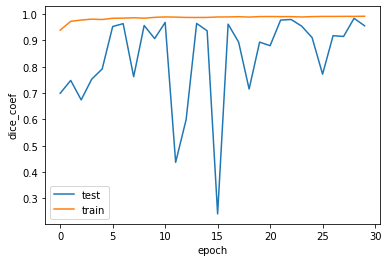

In [37]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

## Претренированная модель

In [38]:
pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58892288/58889256 [==============================] - 14s 0us/step


In [39]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [40]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [41]:
modelU = unet_pre_train(num_classes = 2, input_shape= (200, 600, 3))

plot_model(modelU, to_file='modelU.png')

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_4[0][0]         

In [43]:
historyU = modelU.fit(xTrain, yTrain, epochs=30, batch_size=3, 
                      validation_data=(xTrain, yTrain), 
                      callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 )])

Epoch 1/30
27/27 [==============================] - 15s 406ms/step - loss: 0.3506 - dice_coef: 0.7826 - val_loss: 0.2671 - val_dice_coef: 0.8048
Epoch 2/30
27/27 [==============================] - 8s 300ms/step - loss: 0.0856 - dice_coef: 0.9428 - val_loss: 0.2028 - val_dice_coef: 0.8903
Epoch 3/30
27/27 [==============================] - 8s 288ms/step - loss: 0.0415 - dice_coef: 0.9716 - val_loss: 0.1799 - val_dice_coef: 0.9133
Epoch 4/30
27/27 [==============================] - 8s 292ms/step - loss: 0.0233 - dice_coef: 0.9823 - val_loss: 0.0713 - val_dice_coef: 0.9493
Epoch 5/30
27/27 [==============================] - 8s 290ms/step - loss: 0.0191 - dice_coef: 0.9847 - val_loss: 0.0414 - val_dice_coef: 0.9680
Epoch 6/30
27/27 [==============================] - 8s 293ms/step - loss: 0.0186 - dice_coef: 0.9851 - val_loss: 0.0214 - val_dice_coef: 0.9838
Epoch 7/30
27/27 [==============================] - 8s 290ms/step - loss: 0.0174 - dice_coef: 0.9855 - val_loss: 0.0769 - val_dice_coef

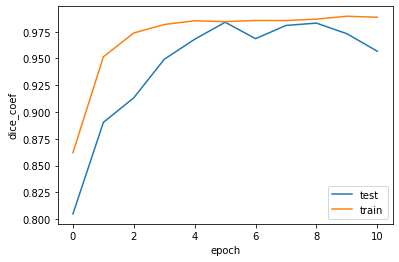

In [44]:
plt.plot(historyU.history['val_dice_coef'],label = 'test')
plt.plot(historyU.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

## Вывод

1. Претренированная модель показывает лучшие результаты (более гладкая кривая обучения) - попробовать прогнать обучение на всем датасете и на большем количестве эпох.
2. Организовать поэтапную загрузку в память данных для тренировки - на полном датасете ядро падает по памяти.